In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

import graphviz
from graphviz import Graph

import env
import wrangle_zillow
import os

# turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")

In [2]:
# change display settings to show all columns
pd.set_option("display.max_columns", None)

In [3]:
# use a function to pull in zillow data
df = wrangle_zillow.wrangle_zillow()
df.shape

(50782, 25)

In [4]:
# use a function to split data for exploring and modeling
train, validate, test = wrangle_zillow.split_data(df)
train.head(3)

,bathrooms,bedrooms,area,counties,latitude,longitude,lot_area,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvalue,taxvalue,assessmentyear,landtaxvalue,taxamount,logerror,transactiondate,los_angeles,orange,ventura,age,age_bin,bath_bed_ratio
0,2.0,4,1352,los_angeles,34273883,-118492869,6925,12447.0,3101,96370,0.0,1955.0,148000,505000,2016,357000,6228,0.027193,2017-02-27,1,0,0,62,"(60, 70]",0.50
1,3.0,4,1980,los_angeles,34362339,-117653901,8763,21395.0,3101,97324,0.0,1981.0,243342,303236,2016,59894,3275,0.145576,2017-09-13,1,0,0,36,"(30, 40]",0.75
2,3.0,3,1484,los_angeles,34288283,-118376120,12470,12447.0,3101,96368,0.0,1990.0,177997,311590,2016,133593,3881,-0.034493,2017-03-13,1,0,0,27,"(20, 30]",1.00


In [5]:
train.head()

,bathrooms,bedrooms,area,counties,latitude,longitude,lot_area,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvalue,taxvalue,assessmentyear,landtaxvalue,taxamount,logerror,transactiondate,los_angeles,orange,ventura,age,age_bin,bath_bed_ratio
0,2.0,4,1352,los_angeles,34273883,-118492869,6925,12447.0,3101,96370,0.0,1955.0,148000,505000,2016,357000,6228,0.027193,2017-02-27,1,0,0,62,"(60, 70]",0.500000
1,3.0,4,1980,los_angeles,34362339,-117653901,8763,21395.0,3101,97324,0.0,1981.0,243342,303236,2016,59894,3275,0.145576,2017-09-13,1,0,0,36,"(30, 40]",0.750000
2,3.0,3,1484,los_angeles,34288283,-118376120,12470,12447.0,3101,96368,0.0,1990.0,177997,311590,2016,133593,3881,-0.034493,2017-03-13,1,0,0,27,"(20, 30]",1.000000
3,2.0,3,1731,orange,33883151,-117869121,8000,26531.0,1286,97068,7.0,1963.0,52482,73745,2016,21263,1353,0.023989,2017-01-03,0,1,0,54,"(50, 60]",0.666667
4,1.0,3,1011,los_angeles,33921848,-118247414,5970,118994.0,3101,96040,0.0,1946.0,43615,136298,2016,92683,2101,0.017609,2017-06-20,1,0,0,71,"(70, 80]",0.333333


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28437 entries, 0 to 28436
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   bathrooms          28437 non-null  float64 
 1   bedrooms           28437 non-null  int64   
 2   area               28437 non-null  int64   
 3   counties           28437 non-null  object  
 4   latitude           28437 non-null  int64   
 5   longitude          28437 non-null  int64   
 6   lot_area           28437 non-null  int64   
 7   regionidcity       28437 non-null  float64 
 8   regionidcounty     28437 non-null  object  
 9   regionidzip        28437 non-null  object  
 10  roomcnt            28437 non-null  float64 
 11  yearbuilt          28437 non-null  float64 
 12  structuretaxvalue  28437 non-null  int64   
 13  taxvalue           28437 non-null  int64   
 14  assessmentyear     28437 non-null  object  
 15  landtaxvalue       28437 non-null  int64   
 16  taxa

In [7]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
bathrooms,28437.0,2.249587e+00,0.930388,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.000000e+01
bedrooms,28437.0,3.283258e+00,0.915116,1.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,1.100000e+01
area,28437.0,1.857225e+03,852.835796,1.520000e+02,1.260000e+03,1.639000e+03,2.243000e+03,1.068600e+04
latitude,28437.0,3.402483e+07,275212.666372,3.334062e+07,3.382658e+07,3.402160e+07,3.419112e+07,3.481877e+07
longitude,28437.0,-1.181913e+08,357901.206311,-1.194479e+08,-1.183944e+08,-1.181472e+08,-1.179283e+08,-1.175546e+08
lot_area,28437.0,1.141718e+04,105468.851402,4.800000e+02,5.558000e+03,6.763000e+03,8.568000e+03,6.971010e+06
regionidcity,28437.0,3.338290e+04,49436.242536,3.491000e+03,1.244700e+04,2.481200e+04,4.022700e+04,3.965560e+05
roomcnt,28437.0,1.915849e+00,3.144343,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,1.400000e+01
yearbuilt,28437.0,1.963237e+03,22.905144,1.878000e+03,1.950000e+03,1.961000e+03,1.979000e+03,2.015000e+03
structuretaxvalue,28437.0,1.719909e+05,149790.602082,1.480000e+02,7.577100e+04,1.286320e+05,2.149680e+05,1.646927e+06


<AxesSubplot:>

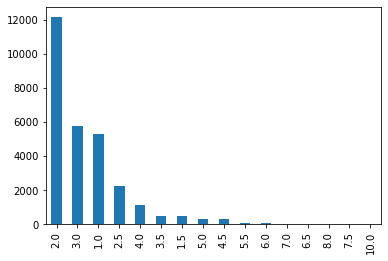

In [8]:
# check bathroom value counts
train.bathrooms.value_counts().plot.bar()

<AxesSubplot:>

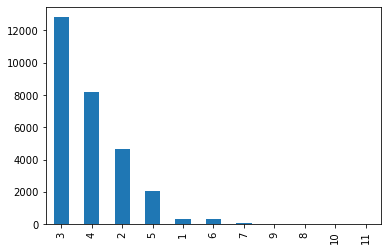

In [9]:
# check bedroom value counts
train.bedrooms.value_counts().plot.bar()

<AxesSubplot:>

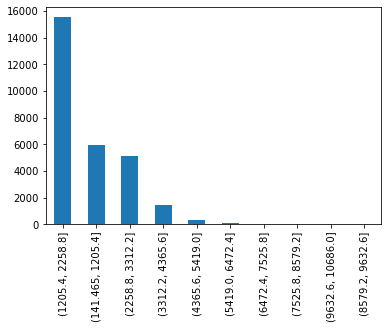

In [10]:
# check binned area value counts
train.area.value_counts(bins=10).plot.bar()

<AxesSubplot:>

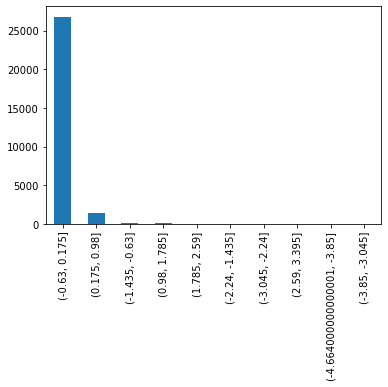

In [11]:
# check binned logerror value counts
train.logerror.value_counts(bins=10).plot.bar()

<AxesSubplot:>

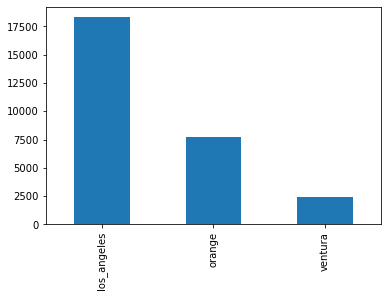

In [12]:
# check binned logerror value counts
train.counties.value_counts().plot.bar()

In [13]:
# for col in train.columns:
#     plt.figure(figsize=(4,2))
#     plt.hist(train[col])
#     plt.title(col)
#     plt.show()

### Takeaways:

#### Many of the features seem to be skewed to the right

#### Bathrooms, bedrooms, area, and age have the highest correlation with logerror

#### There are almost twice as many properties in LA County than Orange & Ventura county

## Is there difference in mean logerror for each of the counties?

In [14]:
train.head(3)

,bathrooms,bedrooms,area,counties,latitude,longitude,lot_area,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvalue,taxvalue,assessmentyear,landtaxvalue,taxamount,logerror,transactiondate,los_angeles,orange,ventura,age,age_bin,bath_bed_ratio
0,2.0,4,1352,los_angeles,34273883,-118492869,6925,12447.0,3101,96370,0.0,1955.0,148000,505000,2016,357000,6228,0.027193,2017-02-27,1,0,0,62,"(60, 70]",0.50
1,3.0,4,1980,los_angeles,34362339,-117653901,8763,21395.0,3101,97324,0.0,1981.0,243342,303236,2016,59894,3275,0.145576,2017-09-13,1,0,0,36,"(30, 40]",0.75
2,3.0,3,1484,los_angeles,34288283,-118376120,12470,12447.0,3101,96368,0.0,1990.0,177997,311590,2016,133593,3881,-0.034493,2017-03-13,1,0,0,27,"(20, 30]",1.00


In [15]:
# check mean logerror for each county
train.groupby('counties').logerror.mean()

counties
los_angeles    0.015888
orange         0.023104
ventura        0.016805
Name: logerror, dtype: float64

In [16]:
# code is not producing the same result as groupby likely due to rounding
train[train.counties == 'los_angeles'].logerror.mean()

0.015888107084402518

In [17]:
# code is not producing the same result as groupby likely due to rounding
train[train.counties == 'orange'].logerror.mean()

0.02310369821347422

In [18]:
# code is not producing the same result as groupby likely due to rounding
train[train.counties == 'ventura'].logerror.mean()

0.016804598418300867

**My project partner explored this in greater depth with statistical testing and determined there was a significant difference in logerror by county**

In [19]:
# Use .describe with object columns.
obj_cols = train.columns[[train[col].dtype == 'O' for col in train.columns]]
for col in obj_cols:
    print(train[col].value_counts())
    print(train[col].value_counts(normalize=True, dropna=False))
    print('----------------------')

los_angeles    18299
orange          7707
ventura         2431
Name: counties, dtype: int64
los_angeles    0.643493
orange         0.271020
ventura        0.085487
Name: counties, dtype: float64
----------------------
3101    18299
1286     7707
2061     2431
Name: regionidcounty, dtype: int64
3101    0.643493
1286    0.271020
2061    0.085487
Name: regionidcounty, dtype: float64
----------------------
97319    435
97318    370
97328    298
97329    295
97118    284
        ... 
96434      2
95996      1
96467      1
96038      1
96323      1
Name: regionidzip, Length: 376, dtype: int64
97319    0.015297
97318    0.013011
97328    0.010479
97329    0.010374
97118    0.009987
           ...   
96434    0.000070
95996    0.000035
96467    0.000035
96038    0.000035
96323    0.000035
Name: regionidzip, Length: 376, dtype: float64
----------------------
2016    28437
Name: assessmentyear, dtype: int64
2016    1.0
Name: assessmentyear, dtype: float64
----------------------
2017-06-30    440

## What does absolute logerror look like from county to county?

In [20]:
# check the range for logerror
train.logerror.describe()

count    28437.000000
mean         0.017922
std          0.176460
min         -4.655420
25%         -0.024978
50%          0.006541
75%          0.039383
max          3.394544
Name: logerror, dtype: float64

In [21]:
# add a column that bins each value of logerror into max, min, or med absolute error
train['log_e'] = pd.cut(train.logerror, bins=[-5,-1,-.03,.03,1,5], ordered=False, labels=['max','med','min','med','max'])
train.head()

,bathrooms,bedrooms,area,counties,latitude,longitude,lot_area,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvalue,taxvalue,assessmentyear,landtaxvalue,taxamount,logerror,transactiondate,los_angeles,orange,ventura,age,age_bin,bath_bed_ratio,log_e
0,2.0,4,1352,los_angeles,34273883,-118492869,6925,12447.0,3101,96370,0.0,1955.0,148000,505000,2016,357000,6228,0.027193,2017-02-27,1,0,0,62,"(60, 70]",0.500000,min
1,3.0,4,1980,los_angeles,34362339,-117653901,8763,21395.0,3101,97324,0.0,1981.0,243342,303236,2016,59894,3275,0.145576,2017-09-13,1,0,0,36,"(30, 40]",0.750000,med
2,3.0,3,1484,los_angeles,34288283,-118376120,12470,12447.0,3101,96368,0.0,1990.0,177997,311590,2016,133593,3881,-0.034493,2017-03-13,1,0,0,27,"(20, 30]",1.000000,med
3,2.0,3,1731,orange,33883151,-117869121,8000,26531.0,1286,97068,7.0,1963.0,52482,73745,2016,21263,1353,0.023989,2017-01-03,0,1,0,54,"(50, 60]",0.666667,min
4,1.0,3,1011,los_angeles,33921848,-118247414,5970,118994.0,3101,96040,0.0,1946.0,43615,136298,2016,92683,2101,0.017609,2017-06-20,1,0,0,71,"(70, 80]",0.333333,min


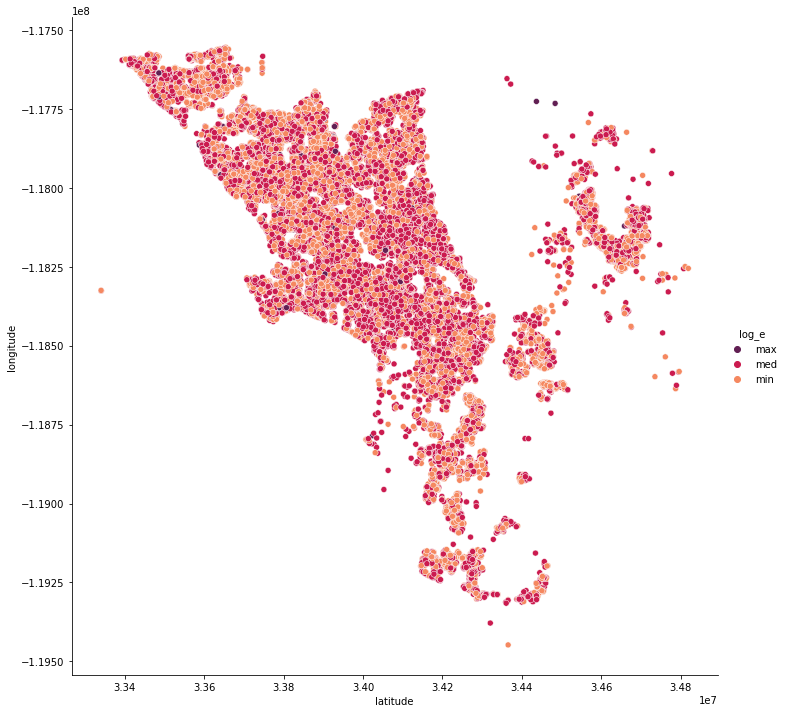

In [22]:
# plot the data to see which areas have the most logerror
sns.relplot(data=train, x='latitude', y='longitude', hue='log_e', hue_order=['max', 'med','min'], height=10, palette='rocket')

### As seen towards the center of the graph, Los Angeles County does have a higher proportion of med - max logerror which could mean the model has a harder time predicting home values from this location or could just be due to the larger number of properties sold in this area

In [23]:
# use crosstab to visualize the number of each category per county
pd.crosstab(train.counties, train.log_e)

log_e,max,med,min
counties,,,
los_angeles,70,10204,8025
orange,60,3522,4125
ventura,9,1118,1304


<AxesSubplot:xlabel='counties', ylabel='proportion'>

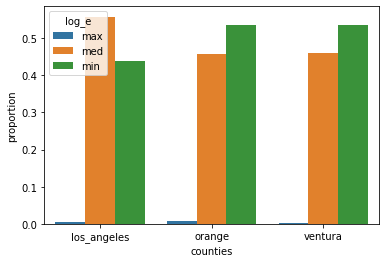

In [24]:
# plot the data to see if any county has a higher percentage of max logerrors
x, y, hue = 'counties', 'proportion', 'log_e'
hue_order = ['max', 'med', 'min']

(train[hue]
 .groupby(train[x])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

### We can barely see on the graph but it looks like the model produces a slightly higher percentage of max errors for Orange County but a higher percentage of medium error for Los Angeles County

In [25]:
# drop log_e to prep for clustering
train = train.drop(columns='log_e')
train.head()

,bathrooms,bedrooms,area,counties,latitude,longitude,lot_area,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvalue,taxvalue,assessmentyear,landtaxvalue,taxamount,logerror,transactiondate,los_angeles,orange,ventura,age,age_bin,bath_bed_ratio
0,2.0,4,1352,los_angeles,34273883,-118492869,6925,12447.0,3101,96370,0.0,1955.0,148000,505000,2016,357000,6228,0.027193,2017-02-27,1,0,0,62,"(60, 70]",0.500000
1,3.0,4,1980,los_angeles,34362339,-117653901,8763,21395.0,3101,97324,0.0,1981.0,243342,303236,2016,59894,3275,0.145576,2017-09-13,1,0,0,36,"(30, 40]",0.750000
2,3.0,3,1484,los_angeles,34288283,-118376120,12470,12447.0,3101,96368,0.0,1990.0,177997,311590,2016,133593,3881,-0.034493,2017-03-13,1,0,0,27,"(20, 30]",1.000000
3,2.0,3,1731,orange,33883151,-117869121,8000,26531.0,1286,97068,7.0,1963.0,52482,73745,2016,21263,1353,0.023989,2017-01-03,0,1,0,54,"(50, 60]",0.666667
4,1.0,3,1011,los_angeles,33921848,-118247414,5970,118994.0,3101,96040,0.0,1946.0,43615,136298,2016,92683,2101,0.017609,2017-06-20,1,0,0,71,"(70, 80]",0.333333


In [26]:
# use a function to create X and y datasets for train, validate, and test
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle_zillow.prep_zillow_for_model(train, validate, test)
X_train.head(2)

,bathrooms,bedrooms,area,latitude,longitude,lot_area,regionidcity,roomcnt,yearbuilt,structuretaxvalue,taxvalue,landtaxvalue,taxamount,los_angeles,orange,ventura,age,bath_bed_ratio
0,0.111111,0.3,0.113917,0.631374,0.504448,0.000925,0.022785,0.0,0.562044,0.089783,0.251761,0.192804,0.105471,1.0,0.0,0.0,0.437956,0.041096
1,0.222222,0.3,0.173533,0.691216,0.947571,0.001188,0.045550,0.0,0.751825,0.147679,0.150522,0.032274,0.055065,1.0,0.0,0.0,0.248175,0.075342


In [27]:
y_train.isnull().sum()

logerror    0
dtype: int64

In [28]:
# select the features to use
X = X_train[['age', 'taxvalue']]
X2 = X_validate[['age', 'taxvalue']]
X3 = X_test[['age', 'taxvalue']]

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'taxvalue'}>]], dtype=object)

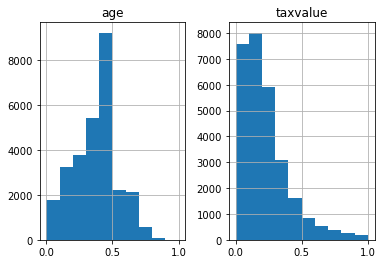

In [29]:
# visualize distribution
X.hist()

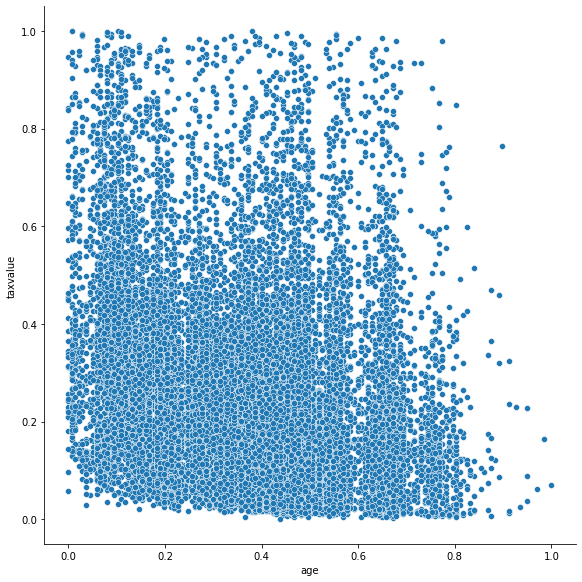

In [30]:
# visualize data to see if there are any obvious clusters
sns.relplot(x = 'age', y ='taxvalue', data = X, height=8)

**There are no obvious clusters so I will use the elbow method to see if I can find a good value for k**

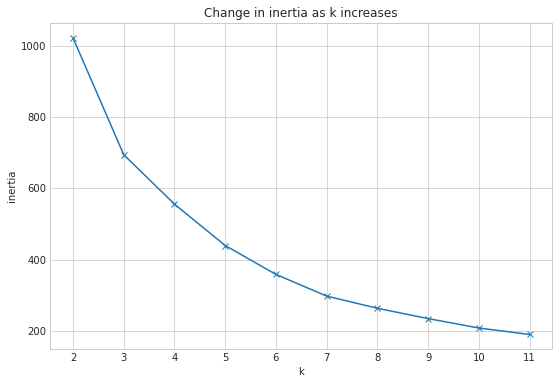

In [31]:
# use elbow method to see what might be a good value for k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

### Based on this visualization, I will start by using a k of 5 since the slope starts tapering off after that

In [32]:
# use KMeans to create cluster

# define the thing
kmeans = KMeans(n_clusters=5, random_state = 369)

# fit the thing
kmeans.fit(X)

# Use the thing to predict
kmeans.predict(X)

array([1, 0, 0, ..., 4, 0, 1], dtype=int32)

In [33]:
# create a new column with the predicted cluster in the original X_dataframes
X_train['agetax_cluster'] = kmeans.predict(X)
X_validate['agetax_cluster'] = kmeans.predict(X2)
X_test['agetax_cluster'] = kmeans.predict(X3)
X_train.head(2)

,bathrooms,bedrooms,area,latitude,longitude,lot_area,regionidcity,roomcnt,yearbuilt,structuretaxvalue,taxvalue,landtaxvalue,taxamount,los_angeles,orange,ventura,age,bath_bed_ratio,agetax_cluster
0,0.111111,0.3,0.113917,0.631374,0.504448,0.000925,0.022785,0.0,0.562044,0.089783,0.251761,0.192804,0.105471,1.0,0.0,0.0,0.437956,0.041096,1
1,0.222222,0.3,0.173533,0.691216,0.947571,0.001188,0.045550,0.0,0.751825,0.147679,0.150522,0.032274,0.055065,1.0,0.0,0.0,0.248175,0.075342,0


In [34]:
X_validate.head(2)

,bathrooms,bedrooms,area,latitude,longitude,lot_area,regionidcity,roomcnt,yearbuilt,structuretaxvalue,taxvalue,landtaxvalue,taxamount,los_angeles,orange,ventura,age,bath_bed_ratio,agetax_cluster
0,0.000000,0.1,0.069584,0.401116,0.659906,0.000621,0.074097,0.0,0.481752,0.044915,0.135911,0.107977,0.065290,1.0,0.0,0.0,0.518248,0.041096,4
1,0.111111,0.2,0.141067,0.373566,0.720836,0.001059,0.127574,0.0,0.620438,0.028568,0.032220,0.010867,0.019237,1.0,0.0,0.0,0.379562,0.063927,4


In [35]:
# create dataframe of cluster centers
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

,age,taxvalue
0,0.177175,0.234245
1,0.437663,0.336888
2,0.253094,0.680267
3,0.648508,0.132691
4,0.415415,0.106581


<AxesSubplot:xlabel='age', ylabel='taxvalue'>

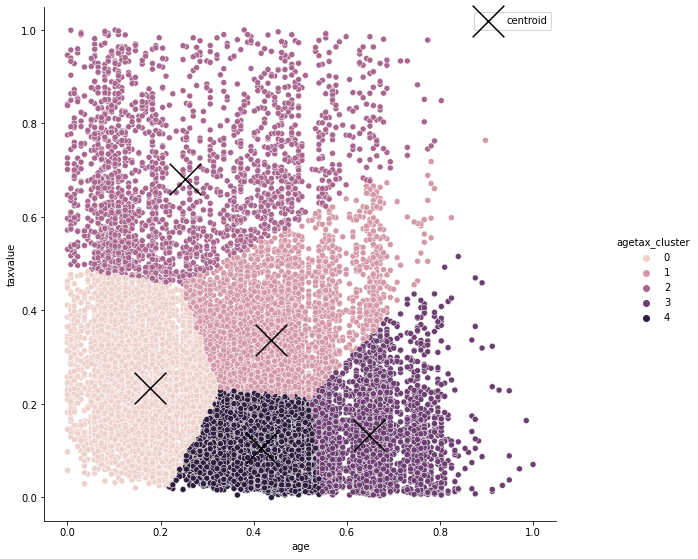

In [36]:
# visualize clustering results
sns.relplot(x = 'age', y ='taxvalue', data = X_train, hue = 'agetax_cluster')

centroids.plot.scatter(x='age', y='taxvalue', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid', figsize=(10, 8))

<AxesSubplot:xlabel='agetax_cluster', ylabel='logerror'>

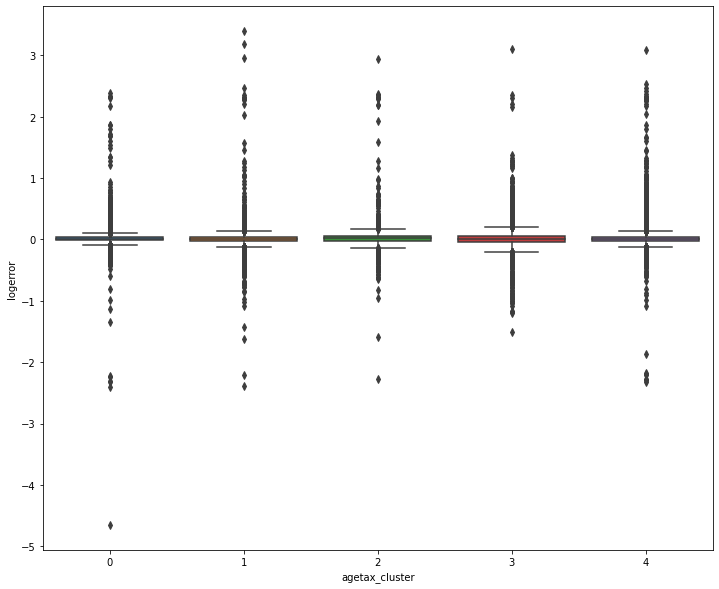

In [37]:
# concatenate X and y train dataframes to plot data
Xy_train = pd.concat([X_train, y_train], axis=1)

# visualize distribution of logerror by cluster
plt.figure(figsize=(12,10))
sns.boxplot(
    x='agetax_cluster',
    y='logerror',
    data=Xy_train)

<AxesSubplot:xlabel='age', ylabel='taxvalue'>

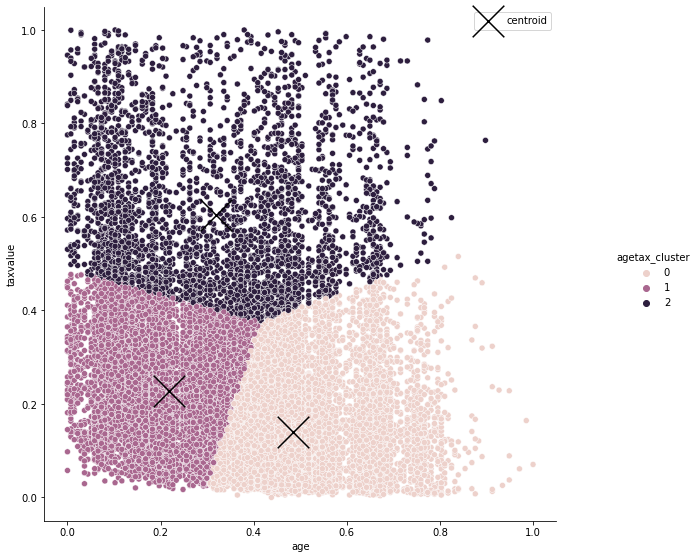

In [38]:
# use KMeans to create 3 clusters to see if that may be more meaningful
# define the thing
kmeans = KMeans(n_clusters=3, random_state = 369)

# fit the thing
kmeans.fit(X)

# Use the thing to predict
kmeans.predict(X)

# create a new column with the predicted cluster in the original X_dataframes
X_train['agetax_cluster'] = kmeans.predict(X)
X_validate['agetax_cluster'] = kmeans.predict(X2)
X_test['agetax_cluster'] = kmeans.predict(X3)

# create dataframe of cluster centers
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)

# visualize clustering results
sns.relplot(x = 'age', y ='taxvalue', data = X_train, hue = 'agetax_cluster')

centroids.plot.scatter(x='age', y='taxvalue', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid', figsize=(10, 8))

<AxesSubplot:xlabel='agetax_cluster', ylabel='logerror'>

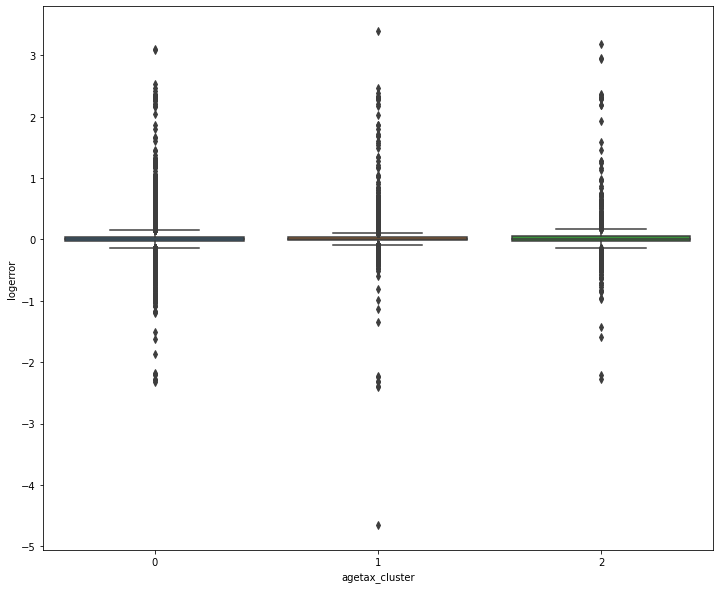

In [39]:
# concatenate X and y train dataframes to plot data
Xy_train = pd.concat([X_train, y_train], axis=1)

# visualize distribution of logerror by cluster
plt.figure(figsize=(12,10))
sns.boxplot(
    x='agetax_cluster',
    y='logerror',
    data=Xy_train)

### Although the visual does not make it appear that there is much of a difference in logerror for each cluster, I am going to apply a statistical test to confirm this.

**The null hypothesis for the levene test is that there is equal variance in logerror for the clusters**

**The alternate hypothesis for the levene test is that there is unequal variance in logerror for the clusters**

In [40]:
# set alpha
alpha = 0.05

# use levene test to check variance of each cluster
stat, pvalue = stats.levene(
                            Xy_train[Xy_train.agetax_cluster == 0].logerror,
                            Xy_train[Xy_train.agetax_cluster == 1].logerror,
                            Xy_train[Xy_train.agetax_cluster == 2].logerror)

print(f'{stat}, {pvalue}')
if pvalue > alpha:
    print('We fail to reject the null hypothesis')
elif pvalue < alpha:
    print('We reject the null hypothesis')

75.23485872054115, 2.5826532997667535e-33
We reject the null hypothesis


**Because of unequal variance, I will use the Kruskal-Wallis test to compare the median logerror for each cluster**

**The null hypothesis is that there is no significant difference in the median logerror for each of the clusters**

**The alternate hypothesis is that there is a significant difference in the median logerror for each of the clusters**

In [41]:
# set alpha
alpha = 0.05

# use kruskal-wallis test to compare medians
stat, pvalue = stats.kruskal(
    Xy_train[Xy_train.agetax_cluster == 0].logerror,
    Xy_train[Xy_train.agetax_cluster == 1].logerror,
    Xy_train[Xy_train.agetax_cluster == 2].logerror)

print(f'{stat}, {pvalue}')
if pvalue > alpha:
    print('We fail to reject the null hypothesis')
elif pvalue < alpha:
    print('We reject the null hypothesis')

43.24287152303828, 4.073143941365692e-10
We reject the null hypothesis


### It appears there is a statistically significant difference in logerror for at least two of the clusters

**I am going to use selectkbest and recursive feature elimination to see what features might be most relevant**

In [42]:
# parameters: f_regression stats test, give me 3 features
f_selector = SelectKBest(f_regression, k=3)

# find the top 3 X's correlated with y
f_selector.fit(X_train, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train.iloc[:,feature_mask].columns.tolist()
f_feature

['bathrooms', 'bedrooms', 'area']

In [43]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=3)

# fit the data using RFE
rfe.fit(X_train,y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train.iloc[:,feature_mask].columns.tolist()
rfe_feature

['los_angeles', 'orange', 'ventura']

In [44]:
# select the features to use
X = X_train[['bathrooms', 'bedrooms', 'area']]
X2 = X_validate[['bathrooms', 'bedrooms', 'area']]
X3 = X_test[['bathrooms', 'bedrooms', 'area']]

array([[<AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'bedrooms'}>],
       [<AxesSubplot:title={'center':'area'}>, <AxesSubplot:>]],
      dtype=object)

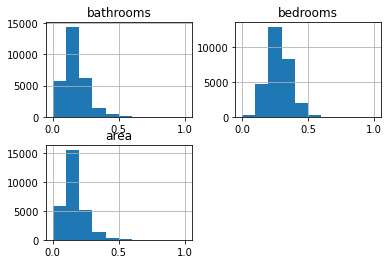

In [45]:
# visualize distribution for X
X.hist()

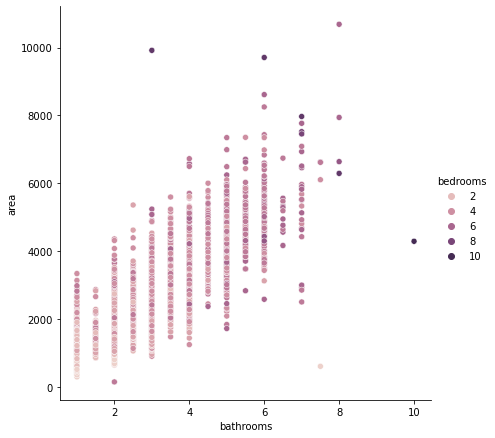

In [46]:
# visualize data to see if there are any obvious clusters
sns.relplot(x = 'bathrooms', y ='area', hue='bedrooms', data = train, height=6)

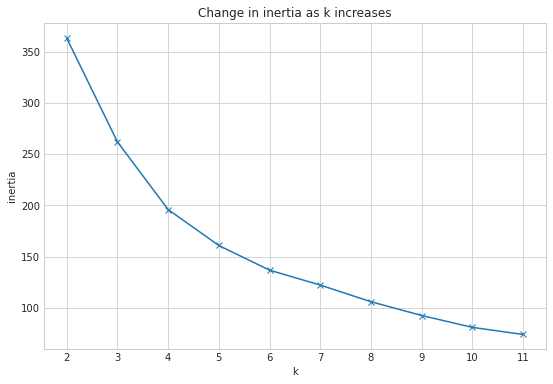

In [47]:
# use elbow method to see what might be a good value for k
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

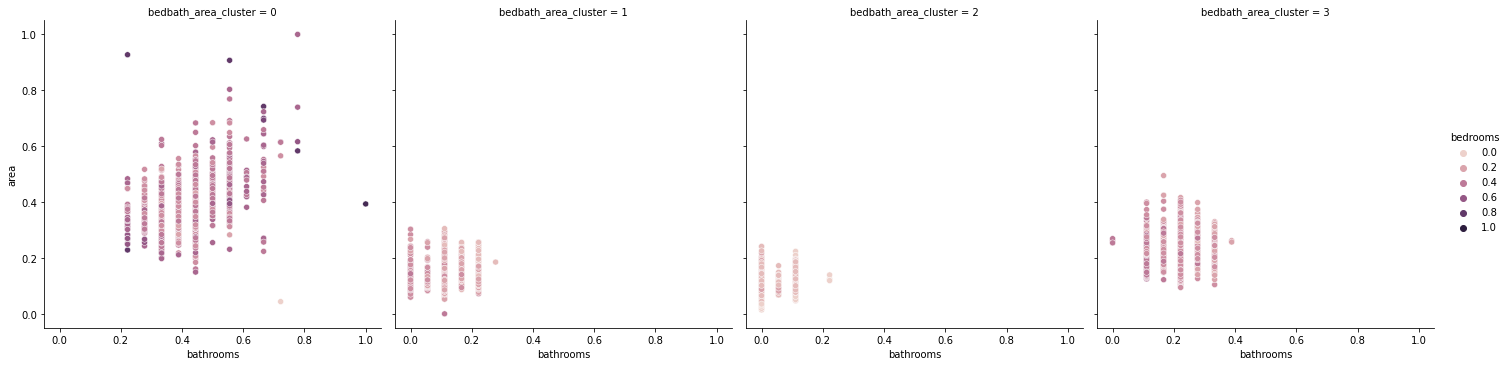

In [48]:
# use KMeans to create 4 clusters

# define the thing
kmeans = KMeans(n_clusters=4, random_state = 369)

# fit the thing
kmeans.fit(X)

# Use the thing to predict
kmeans.predict(X)

# create a new column with the predicted cluster in the original X_train
X_train['bedbath_area_cluster'] = kmeans.predict(X)
X_validate['bedbath_area_cluster'] = kmeans.predict(X2)
X_test['bedbath_area_cluster'] = kmeans.predict(X3)

# create dataframe of cluster centers
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)

# visualize clustering results
sns.relplot(x = 'bathrooms', y ='area', data = X_train, hue = 'bedrooms', col='bedbath_area_cluster')

<AxesSubplot:xlabel='bedbath_area_cluster', ylabel='logerror'>

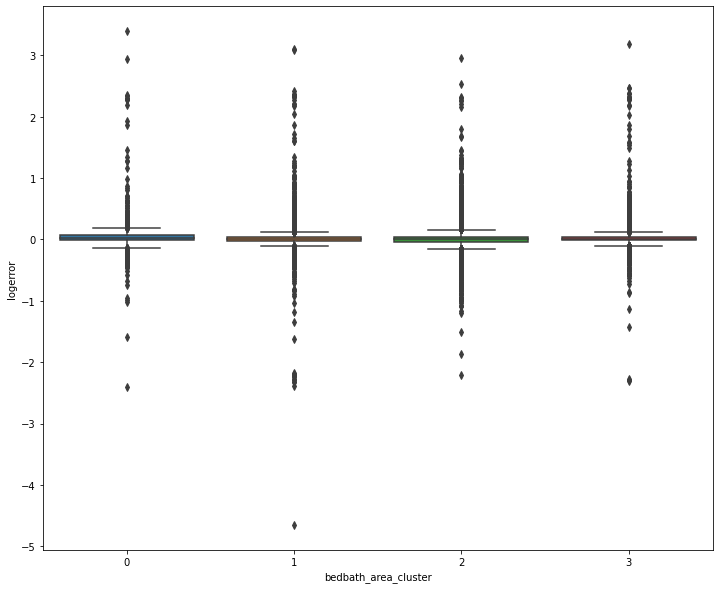

In [49]:
# concatenate X and y train dataframes to plot data
Xy_train = pd.concat([X_train, y_train], axis=1)

# visualize distribution of logerror by cluster
plt.figure(figsize=(12,10))
sns.boxplot(
    x='bedbath_area_cluster',
    y='logerror',
    data=Xy_train)

**The null hypothesis for the levene test is that there is equal variance in logerror for the clusters**

**The alternate hypothesis for the levene test is that there is unequal variance in logerror for the clusters**

In [50]:
# set alpha
alpha = 0.05

# use levene test to check variance of each cluster
stat, pvalue = stats.levene(
                            Xy_train[Xy_train.bedbath_area_cluster == 0].logerror,
                            Xy_train[Xy_train.bedbath_area_cluster == 1].logerror,
                            Xy_train[Xy_train.bedbath_area_cluster == 2].logerror,
                            Xy_train[Xy_train.bedbath_area_cluster == 2].logerror)

print(f'{stat}, {pvalue}')
if pvalue > alpha:
    print('We fail to reject the null hypothesis')
elif pvalue < alpha:
    print('We reject the null hypothesis')

62.98839709317187, 1.396192057706921e-40
We reject the null hypothesis


**Because of unequal variance, I will use the Kruskal-Wallis test to compare the mean logerror for each cluster**

**The null hypothesis is that there is no significant difference in the median logerror for each of the clusters**

**The alternate hypothesis is that there is a significant difference in the median logerror for each of the clusters**

In [51]:
# set alpha
alpha = 0.05

# use kruskal-wallis test to compare medians
stats.kruskal(
    Xy_train[Xy_train.bedbath_area_cluster == 0].logerror,
    Xy_train[Xy_train.bedbath_area_cluster == 1].logerror,
    Xy_train[Xy_train.bedbath_area_cluster == 2].logerror)

print(f'{stat}, {pvalue}')
if pvalue > alpha:
    print('We fail to reject the null hypothesis')
elif pvalue < alpha:
    print('We reject the null hypothesis')

62.98839709317187, 1.396192057706921e-40
We reject the null hypothesis


In [52]:
# use groupby to check logerror stats for each of the clusters
Xy_train.groupby('bedbath_area_cluster').logerror.agg(['min', 'median','mean', 'max'])

,min,median,mean,max
bedbath_area_cluster,,,,
0,-2.406257,0.021722,0.044289,3.394544
1,-4.655420,0.004700,0.013940,3.100913
2,-2.211811,0.003665,0.014747,2.957147
3,-2.311473,0.008981,0.021403,3.175688


In [53]:
X_train.head(3)

,bathrooms,bedrooms,area,latitude,longitude,lot_area,regionidcity,roomcnt,yearbuilt,structuretaxvalue,taxvalue,landtaxvalue,taxamount,los_angeles,orange,ventura,age,bath_bed_ratio,agetax_cluster,bedbath_area_cluster
0,0.111111,0.3,0.113917,0.631374,0.504448,0.000925,0.022785,0.0,0.562044,0.089783,0.251761,0.192804,0.105471,1.0,0.0,0.0,0.437956,0.041096,0,1
1,0.222222,0.3,0.173533,0.691216,0.947571,0.001188,0.045550,0.0,0.751825,0.147679,0.150522,0.032274,0.055065,1.0,0.0,0.0,0.248175,0.075342,1,3
2,0.222222,0.2,0.126448,0.641116,0.566112,0.001720,0.022785,0.0,0.817518,0.107998,0.154714,0.072095,0.065409,1.0,0.0,0.0,0.182482,0.109589,1,1


In [54]:
# give clusters names
X_train.agetax_cluster = X_train.agetax_cluster.map({0: "older_lowtaxvalue",
                                                     1: "newer_lowtaxvalue",
                                                     2: "all_ages_hightaxvalue"})

X_validate.agetax_cluster = X_validate.agetax_cluster.map({0: "older_lowtaxvalue",
                                                           1: "newer_lowtaxvalue",
                                                           2: "all_ages_hightaxvalue"})

X_test.agetax_cluster = X_test.agetax_cluster.map({0: "older_lowtaxvalue",
                                                     1: "newer_lowtaxvalue",
                                                     2: "all_ages_hightaxvalue"})

X_train.bedbath_area_cluster = X_train.bedbath_area_cluster.map({0: "large_3plusbed",
                                                                 1: "small_2bed",
                                                                 2: "tiny_1bed",
                                                                 3: "medium_3bed"})

X_validate.bedbath_area_cluster = X_validate.bedbath_area_cluster.map({0: "large_3plusbed",
                                                                       1: "small_2bed",
                                                                       2: "tiny_1bed",
                                                                       3: "medium_3bed"})

X_test.bedbath_area_cluster = X_test.bedbath_area_cluster.map({0: "large_3plusbed",
                                                                 1: "small_2bed",
                                                                 2: "tiny_1bed",
                                                                 3: "medium_3bed"})

In [55]:
X_train.agetax_cluster.value_counts()

older_lowtaxvalue        15848
newer_lowtaxvalue         9225
all_ages_hightaxvalue     3364
Name: agetax_cluster, dtype: int64

In [56]:
# encode cluster columns
X_train_model = pd.get_dummies(X_train[['agetax_cluster','bedbath_area_cluster']])
X_validate_model = pd.get_dummies(X_validate[['agetax_cluster','bedbath_area_cluster']])
X_test_model = pd.get_dummies(X_test[['agetax_cluster','bedbath_area_cluster']])
X_train_model.head()

,agetax_cluster_all_ages_hightaxvalue,agetax_cluster_newer_lowtaxvalue,agetax_cluster_older_lowtaxvalue,bedbath_area_cluster_large_3plusbed,bedbath_area_cluster_medium_3bed,bedbath_area_cluster_small_2bed,bedbath_area_cluster_tiny_1bed
0,0,0,1,0,0,1,0
1,0,1,0,0,1,0,0
2,0,1,0,0,0,1,0
3,0,0,1,0,0,1,0
4,0,0,1,0,0,0,1


In [57]:
y_train.head(3)

,logerror
0,0.027193
1,0.145576
2,-0.034493


### First I am going to calculate RMSE for predicting median as the baseline. This will give us something to evaluate our other models against

In [58]:
# turn y for each dataset from a series to a dataframe
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

# create a baseline
y_train['baseline'] = y_train.logerror.median()
y_validate['baseline'] = y_train.logerror.median()
y_test['baseline'] = y_train.logerror.median()

# 4. RMSE of logerror median
rmse_train_baseline = mean_squared_error(y_train.logerror, y_train.baseline)**(1/2)
rmse_validate_baseline = mean_squared_error(y_validate.logerror, y_validate.baseline)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train_baseline, 5), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_baseline, 5))

RMSE using Median
Train/In-Sample:  0.17682 
Validate/Out-of-Sample:  0.16649


### In order to beat baseline, any of the models would need to have a RMSE of less than 0.17682 on the train dataset and 0.16649 on the validate dataset.

## Ordinary Least Squares Model

In [59]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data and specify y column 
lm.fit(X_train_model, y_train.logerror)

# predict train & validate
y_train['logerror_pred_lm'] = lm.predict(X_train_model)
y_validate['logerror_pred_lm'] = lm.predict(X_validate_model)

# evaluate train & validate: rmse
rmse_train_OLS = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm)**(1/2)
rmse_validate_OLS = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", round(rmse_train_OLS, 5), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate_OLS, 5))

RMSE for OLS using LinearRegression
Training/In-Sample:  0.1763 
Validation/Out-of-Sample:  0.16595


## LassoLars Model

In [60]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data and specify y column 
lars.fit(X_train_model, y_train.logerror)

# predict train & validate
y_train['logerror_pred_lars'] = lars.predict(X_train_model)
y_validate['logerror_pred_lars'] = lars.predict(X_validate_model)

# evaluate train & validate: rmse
rmse_train_lars = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars)**(1/2)
rmse_validate_lars = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", round(rmse_train_lars, 5), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate_lars, 5))

RMSE for Lasso + Lars
Training/In-Sample:  0.17646 
Validation/Out-of-Sample:  0.16617


**I tried different values of alpha from .01 to 1.5 and received the same results with all of them.**

## Tweedie Regressor (GLM) Model

<AxesSubplot:>

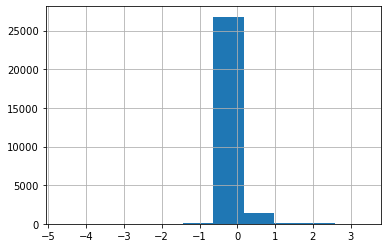

In [61]:
y_train.logerror.hist()

In [62]:
# create the model object
glm = TweedieRegressor(power=0, alpha=0.01)

# fit the model to our training data and specify y column 
glm.fit(X_train_model, y_train.logerror)

# predict train & validate
y_train['logerror_pred_glm'] = glm.predict(X_train_model)
y_validate['logerror_pred_glm'] = glm.predict(X_validate_model)

# evaluate train & validate: rmse
rmse_train_glm = mean_squared_error(y_train.logerror, y_train.logerror_pred_glm)**(1/2)
rmse_validate_glm = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=0 & alpha=1\nTraining/In-Sample: ", round(rmse_train_glm, 5), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate_glm, 5))

RMSE for GLM using Tweedie, power=0 & alpha=1
Training/In-Sample:  0.17629 
Validation/Out-of-Sample:  0.166


**I tried different values for power and alpha from .01 to 1 and achieved the best result with a smaller value of alpha**

## Polynomial Regression

In [63]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_model
X_train_degree2 = pf.fit_transform(X_train_model)

# transform X_validate_model & X_test_model
X_validate_degree2 = pf.transform(X_validate_model)
X_test_degree2 = pf.transform(X_test_model)

In [64]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data and specify y column 
lm2.fit(X_train_degree2, y_train.logerror)

# predict train & validate
y_train['logerror_pred_lm2'] = lm2.predict(X_train_degree2)
y_validate['logerror_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_train_pr = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2)**(1/2)
rmse_validate_pr = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", round(rmse_train_pr, 5), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate_pr, 5))

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.17635 
Validation/Out-of-Sample:  0.1659


In [65]:
X_train_model.head(2)

,agetax_cluster_all_ages_hightaxvalue,agetax_cluster_newer_lowtaxvalue,agetax_cluster_older_lowtaxvalue,bedbath_area_cluster_large_3plusbed,bedbath_area_cluster_medium_3bed,bedbath_area_cluster_small_2bed,bedbath_area_cluster_tiny_1bed
0,0,0,1,0,0,1,0
1,0,1,0,0,1,0,0


### Let's try a subset of the features to see if we get a better result

In [66]:
# select only bed, bath, area cluster features
X_train_bba = X_train_model.iloc[:,3:]
X_validate_bba = X_validate_model.iloc[:,3:]
X_train_bba.head()

,bedbath_area_cluster_large_3plusbed,bedbath_area_cluster_medium_3bed,bedbath_area_cluster_small_2bed,bedbath_area_cluster_tiny_1bed
0,0,0,1,0
1,0,1,0,0
2,0,0,1,0
3,0,0,1,0
4,0,0,0,1


In [67]:
# create the model object
lm3 = LinearRegression(normalize=True)

# fit the model to our training data and specify y column 
lm3.fit(X_train_bba, y_train.logerror)

# predict train & validate
y_train['logerror_pred_lm3'] = lm3.predict(X_train_bba)
y_validate['logerror_pred_lm3'] = lm3.predict(X_validate_bba)

# evaluate train & validate: rmse
rmse_train_sub1 = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm3)**(1/2)
rmse_validate_sub1 = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm3)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", round(rmse_train_sub1, 5), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate_sub1, 5))

RMSE for OLS using LinearRegression
Training/In-Sample:  0.1763 
Validation/Out-of-Sample:  0.16602


In [68]:
# select only age, tax cluster features
X_train_agetax = X_train_model.iloc[:,:3]
X_validate_agetax = X_validate_model.iloc[:,:3]
X_train_agetax.head()

,agetax_cluster_all_ages_hightaxvalue,agetax_cluster_newer_lowtaxvalue,agetax_cluster_older_lowtaxvalue
0,0,0,1
1,0,1,0
2,0,1,0
3,0,0,1
4,0,0,1


In [69]:
# create the model object
lm4 = LinearRegression(normalize=True)

# fit the model to our training data and specify y column 
lm4.fit(X_train_agetax, y_train.logerror)

# predict train & validate
y_train['logerror_pred_lm4'] = lm4.predict(X_train_agetax)
y_validate['logerror_pred_lm4'] = lm4.predict(X_validate_agetax)

# evaluate train & validate: rmse
rmse_train_sub2 = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm4)**(1/2)
rmse_validate_sub2 = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm4)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", round(rmse_train_sub2, 5), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate_sub2, 5))

RMSE for OLS using LinearRegression
Training/In-Sample:  0.17645 
Validation/Out-of-Sample:  0.16616


### Let's try using latitude and longitude as features for modeling using OLS & Polynomial model

In [70]:
# select features to use for modeling
X_train_latlong = X_train[['latitude','longitude']]
X_validate_latlong = X_validate[['latitude','longitude']]
X_train_latlong.head(3)

,latitude,longitude
0,0.631374,0.504448
1,0.691216,0.947571
2,0.641116,0.566112


In [71]:
# create the model object
lm5 = LinearRegression(normalize=True)

# fit the model to our training data and specify y column 
lm5.fit(X_train_latlong, y_train.logerror)

# predict train & validate
y_train['logerror_pred_lm5'] = lm5.predict(X_train_latlong)
y_validate['logerror_pred_lm5'] = lm5.predict(X_validate_latlong)

# evaluate train & validate: rmse
rmse_train_sub3 = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm5)**(1/2)
rmse_validate_sub3 = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm5)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", round(rmse_train_sub3, 5), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate_sub3, 5))

RMSE for OLS using LinearRegression
Training/In-Sample:  0.17643 
Validation/Out-of-Sample:  0.16608


In [72]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_model
X_train_degree2 = pf.fit_transform(X_train_latlong)

# transform X_validate_model & X_test_model
X_validate_degree2 = pf.transform(X_validate_latlong)
# X_test_degree2 = pf.transform(X_test_model)

In [73]:
# create the model object
lm6 = LinearRegression(normalize=True)

# fit the model to our training data and specify y column 
lm6.fit(X_train_degree2, y_train.logerror)

# predict train & validate
y_train['logerror_pred_lm6'] = lm6.predict(X_train_degree2)
y_validate['logerror_pred_lm6'] = lm6.predict(X_validate_degree2)

# evaluate train & validate: rmse
rmse_train_sub3_pr = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm6)**(1/2)
rmse_validate_sub3_pr = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm6)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", round(rmse_train_sub3_pr, 5), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate_sub3_pr, 5))

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.17641 
Validation/Out-of-Sample:  0.16606


## The best model is Tweedie Regressor followed by OLS using the encoded bedbath_area and age_tax features.